# Lyrics detector Challenge

The goal for this challenge is to leverage your knowledge of Deep Learning to design and train a lyrics classifier. For a given verse $X$, our model should learn to predict the artist $y$. The dataset consists of lyrics scrapped from the Genius website.

### Objectives:
- Text preprocessing
- Text embedding
- Train a RNN to detect the artist behind a set of lyrics

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf

## 1. Data Cleaning

Our dataset contains around 4,000 verses of lyrics from different artists: Drake, Ed Sheeran and Kanye West (the verses are given in this order).

In [2]:
raw_data = pd.read_csv("https://wagon-public-datasets.s3.amazonaws.com/certification_france_2021_q2/verses.csv")
data = raw_data.copy() # From now on, update `data` as you see fit and don't touch raw_data
data

,artist,verse
0,Drake,"Ayy, woah Ayy, ayy Yeah"
1,Drake,I'm makin' a change today The liquor been taki...
2,Drake,"I can't just be with you and only you Yeah, I ..."
3,Drake,"Well, summer, all I did was rest, okay? And Ne..."
4,Drake,I'm makin' a change today The liquor been taki...
...,...,...
3970,Kanye West,"Dame was like, ""Yo you got a deal with Capitol..."
3971,Kanye West,"Then one day I just went ahead and played it, ..."
3972,Kanye West,"""I ain't gonna front, it's kinda hot."""
3973,Kanye West,Like they still weren't looking at me like a r...


❓ **Have a look at the verse index 18th**. 
- What do you observe?
- Clean verses from non standard characters using [`unidecode.unidecode()`](https://pypi.org/project/Unidecode/)

In [3]:
pip install unidecode

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [4]:
from unidecode import unidecode

In [5]:
data["verse"] = data["verse"].apply(unidecode)

In [6]:
data

,artist,verse
0,Drake,"Ayy, woah Ayy, ayy Yeah"
1,Drake,I'm makin' a change today The liquor been taki...
2,Drake,"I can't just be with you and only you Yeah, I ..."
3,Drake,"Well, summer, all I did was rest, okay? And Ne..."
4,Drake,I'm makin' a change today The liquor been taki...
...,...,...
3970,Kanye West,"Dame was like, ""Yo you got a deal with Capitol..."
3971,Kanye West,"Then one day I just went ahead and played it, ..."
3972,Kanye West,"""I ain't gonna front, it's kinda hot."""
3973,Kanye West,Like they still weren't looking at me like a r...


❓ **Check if some verses are duplicated.** 
- It can be frequent in music lyrics.
- If so, remove them to avoid data leaks between train and test sets

In [7]:
data.shape

(3975, 2)

In [8]:
data_cleaned = data.drop_duplicates()

In [9]:
data_cleaned.shape

(3031, 2)

In [10]:
from nbresult import ChallengeResult
result = ChallengeResult(
    'data_loading',
    shape=data_cleaned.shape,
    verses=data_cleaned.verse[:50]
)

result.write()

## 2. Data Analysis (given to you)

👉 **We check the number of unique artist and the number of verses per artist**

In [11]:
data_cleaned.artist.value_counts()

Drake         1391
Ed Sheeran     861
Kanye West     779
Name: artist, dtype: int64

In [12]:
data = data_cleaned

In [13]:
data.shape

(3031, 2)

👉 **For each artist, let's have a look at the top-10 most used words to see if they look similar?**

We'll use Tensorflow's [`Tokenizer`](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer)'s index_word

In [14]:
drake = data[data.artist =='Drake'].verse
ed = data[data.artist =='Ed Sheeran'].verse
kanye = data[data.artist =='Kanye West'].verse

In [15]:
tokenizer_drake = tf.keras.preprocessing.text.Tokenizer()
tokenizer_ed = tf.keras.preprocessing.text.Tokenizer()
tokenizer_kanye = tf.keras.preprocessing.text.Tokenizer()

tokenizer_drake.fit_on_texts(drake)
tokenizer_ed.fit_on_texts(ed)
tokenizer_kanye.fit_on_texts(kanye)

In [16]:
pd.DataFrame(data={
    "Drake": pd.Series(tokenizer_drake.index_word)[:10],
    "Ed Sheeran": pd.Series(tokenizer_ed.index_word)[:10],
    "Kanye West": pd.Series(tokenizer_kanye.index_word)[:10],
})

,Drake,Ed Sheeran,Kanye West
1,i,i,i
2,you,you,the
3,the,the,you
4,and,and,and
5,to,me,to
6,a,my,a
7,it,to,my
8,me,a,it
9,i'm,in,me
10,my,i'm,in


👉 **Let's quantify how much vocabulary do they have in common**

- An artist **vocabulary** is the **set** of all unique used words
- We compute the `ratio` of (i) the length of vocabulary they **share**, over (ii) the length of the **total** vocabulary of the dataset

<details>
    <summary>Hints</summary>

We'll use Python [`set.intersection()`](https://www.programiz.com/python-programming/methods/set/intersection) and [`set.union()`](https://www.programiz.com/python-programming/methods/set/union)
</details>

In [17]:
drake_vocabulary = set(tokenizer_drake.index_word.values())
ed_vocabulary = set(tokenizer_ed.index_word.values())
kanye_vocabulary = set(tokenizer_kanye.index_word.values())

In [18]:
common_vocabulary = drake_vocabulary.intersection(ed_vocabulary).intersection(kanye_vocabulary)
global_vocabulary = drake_vocabulary.union(ed_vocabulary).union(kanye_vocabulary)

ratio = len(common_vocabulary)/len(global_vocabulary)
print(f"{ratio*100:.2f}% of the artists' vocabulary is common")

15.28% of the artists' vocabulary is common


## 3. Data Preprocessing

### 3.1 Word Embedding
We now need to think about embedding our sentences into numbers. We will be using [`gensim.models.Word2Vec`](https://radimrehurek.com/gensim/models/word2vec.html#gensim.models.word2vec.Word2Vec) to embed each word of the sentence and concatenate the embeddings of the words forming the sentence.

❓ **Transform the list of strings (verses) into a list of word sequences (a word sequence is a list of words contained in a string)**
- Store these sequences of words in a new column `data["seq"]` in your dataframe
- You can use `tensorflow.keras.preprocessing.text.text_to_word_sequence` 

In [19]:
# YOUR CODE HERE
data["seq"] = data["verse"].apply(tf.keras.preprocessing.text.text_to_word_sequence)

<ipython-input-19-805f1f9ccfca>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["seq"] = data["verse"].apply(tf.keras.preprocessing.text.text_to_word_sequence)


In [20]:
data

,artist,verse,seq
0,Drake,"Ayy, woah Ayy, ayy Yeah","[ayy, woah, ayy, ayy, yeah]"
1,Drake,I'm makin' a change today The liquor been taki...,"[i'm, makin', a, change, today, the, liquor, b..."
2,Drake,"I can't just be with you and only you Yeah, I ...","[i, can't, just, be, with, you, and, only, you..."
3,Drake,"Well, summer, all I did was rest, okay? And Ne...","[well, summer, all, i, did, was, rest, okay, a..."
4,Drake,I'm makin' a change today The liquor been taki...,"[i'm, makin', a, change, today, the, liquor, b..."
...,...,...,...
3970,Kanye West,"Dame was like, ""Yo you got a deal with Capitol...","[dame, was, like, yo, you, got, a, deal, with,..."
3971,Kanye West,"Then one day I just went ahead and played it, ...","[then, one, day, i, just, went, ahead, and, pl..."
3972,Kanye West,"""I ain't gonna front, it's kinda hot.""","[i, ain't, gonna, front, it's, kinda, hot]"
3973,Kanye West,Like they still weren't looking at me like a r...,"[like, they, still, weren't, looking, at, me, ..."


❓ **Let's check if we can cap the length of each sequences without losing too much information**
- Plot the distribution of sequences lengths using the [`seaborn.kdeplot`](https://seaborn.pydata.org/generated/seaborn.displot.html#seaborn-displot) function
- Does it seem reasonable to limit ourself to 300 words per verse later on? 

In [21]:
# YOUR CODE HERE
data["len"]= data["seq"].apply(lambda x : len(x))

<ipython-input-21-03ec62810863>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["len"]= data["seq"].apply(lambda x : len(x))


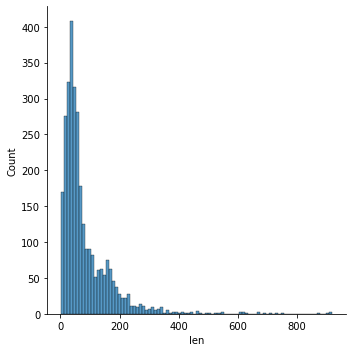

In [22]:
sns.displot(data=data, x="len")

❓ **Keep only the first `300` words of each sequences to reduce the useless long tail of long verses**

In [23]:
# YOUR CODE HERE
data["seq"] = data["seq"].apply(lambda x : x[:300])

<ipython-input-23-55c2bfd6189c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["seq"] = data["seq"].apply(lambda x : x[:300])


In [24]:
data

,artist,verse,seq,len
0,Drake,"Ayy, woah Ayy, ayy Yeah","[ayy, woah, ayy, ayy, yeah]",5
1,Drake,I'm makin' a change today The liquor been taki...,"[i'm, makin', a, change, today, the, liquor, b...",60
2,Drake,"I can't just be with you and only you Yeah, I ...","[i, can't, just, be, with, you, and, only, you...",96
3,Drake,"Well, summer, all I did was rest, okay? And Ne...","[well, summer, all, i, did, was, rest, okay, a...",65
4,Drake,I'm makin' a change today The liquor been taki...,"[i'm, makin', a, change, today, the, liquor, b...",61
...,...,...,...,...
3970,Kanye West,"Dame was like, ""Yo you got a deal with Capitol...","[dame, was, like, yo, you, got, a, deal, with,...",18
3971,Kanye West,"Then one day I just went ahead and played it, ...","[then, one, day, i, just, went, ahead, and, pl...",110
3972,Kanye West,"""I ain't gonna front, it's kinda hot.""","[i, ain't, gonna, front, it's, kinda, hot]",7
3973,Kanye West,Like they still weren't looking at me like a r...,"[like, they, still, weren't, looking, at, me, ...",68


❓ **Train a `gensim.models.Word2Vec` model on your dataset** 
- You want to embed each word into vectors of dimension `100`
- No words should be excluded
- Give Word2Vec at least 50 epochs to be sure it converges
- Store these lists of vectors in a new column `data["embed"]`

In [25]:
pip install gensim

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [26]:
# YOUR CODE HERE
from gensim.models import Word2Vec
word2vec = Word2Vec(sentences=data['seq'], vector_size=100, epochs=50)

/home/thechwal/.local/lib/python3.8/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [27]:
def embed_sentence(word2vec, sentence):
    embedded_sentence = []
    for word in sentence:
        if word in word2vec.wv:
            embedded_sentence.append(word2vec.wv[word])
    return np.array(embedded_sentence)

In [28]:
data["embed"] = data['seq'].apply(lambda x : embed_sentence(word2vec, x))

<ipython-input-28-7608788501c3>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["embed"] = data['seq'].apply(lambda x : embed_sentence(word2vec, x))


In [29]:
# Check 
assert len(data['embed']) == len(data)

### 3.2 Create (X,y)

❓ **Create your numpy array `X` of shape (number_of_verses, 300, 100)**

- 300 words per verse (pad verses shorter than 300 with zeros at the end) 
- each words being a vector of size 100

<img src="https://raw.githubusercontent.com/lewagon/data-images/master/DL/padding.png" width=400>

In [30]:
# YOUR CODE HERE
from tensorflow.keras.preprocessing.sequence import pad_sequences
X = pad_sequences(data['embed'], dtype='float32', padding='post', maxlen=300)

In [31]:
X.shape

(3031, 300, 100)

❓ **Create the numpy array `y` of shape `(n_verses, 3)` that contains the one-hot-encoded list of labels, for the RNN**

In [32]:
# YOUR CODE HERE
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(sparse=False)
y = ohe.fit_transform(data[["artist"]])

In [33]:
y.shape

(3031, 3)

👉 We train/test split the dataset below for you

In [34]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [35]:
from nbresult import ChallengeResult
result = ChallengeResult(
    'data_preprocessing',
    n_zeros = np.sum(X == 0),
    X_shape = X.shape,
    y_shape = y.shape,
)

result.write()

## 4. Recurrent Neural Network

In [45]:
! wget \
'https://wagon-public-datasets.s3.amazonaws.com/certification_france_2021_q2/data_lyrics_solution.pickle'

import pickle
with open("data_lyrics_solution.pickle", "rb") as file:
    (X_train, y_train, X_test, y_test) = pickle.load(file)
    
! rm data_lyrics_solution.pickle -->

--2021-06-29 18:19:02--  https://wagon-public-datasets.s3.amazonaws.com/certification_france_2021_q2/data_lyrics_solution.pickle
Resolving wagon-public-datasets.s3.amazonaws.com (wagon-public-datasets.s3.amazonaws.com)... 52.218.41.50
Connecting to wagon-public-datasets.s3.amazonaws.com (wagon-public-datasets.s3.amazonaws.com)|52.218.41.50|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 727513032 (694M) [application/octet-stream]
Saving to: ‘data_lyrics_solution.pickle’

data_lyrics_solutio 100%[===================>] 693.81M  7.60MB/s    in 84s     

2021-06-29 18:20:25 (8.29 MB/s) - ‘data_lyrics_solution.pickle’ saved [727513032/727513032]

zsh:1: parse error near `>'


❓ **First, store your baseline accuracy to beat as `score_baseline`**
- Consider predicting always the most frequent artist

In [46]:
# YOUR CODE HERE
data["artist"].value_counts()
'''Baseline = most frequent artist / total amount = 1391/3031 = 45.89%'''
score_baseline = 1391/3031

In [47]:
score_baseline

0.45892444737710325

❓ **Create a RNN architecture to predict the artists `y`  given verses `X`** :

- Keep it simple: use only one LSTM layer and one *hidden* dense layer between the input and output layers
- Don't forget to take care of fake "zeros" added during preprocessing
- Store it into the `model` variable.

In [48]:
from tensorflow.keras import Sequential, layers

In [70]:
# YOUR CODE HERE
def init_model():
    model = Sequential()
    model.add(layers.Masking())
    model.add(layers.LSTM(20, activation="tanh"))
    model.add(layers.Dense(3, activation="softmax"))
    model.compile(loss="categorical_crossentropy",
                  optimizer="adam",
                  metrics=["accuracy"])
    return model

In [71]:
model = init_model()

❓ **Train your `model` on the `(X_train, y_train)` training set**
- Use an appropriate loss
- Adapt the learning rate of your optimizer if convergence is too slow/fast
- Make sure your model does not overfit with appropriate control techniques

💡 You will not be judged by the computing power of your computer, you can reach decent performance in less than 3 minutes of training without GPUs.

In [62]:
X_train.shape

(2424, 300, 100)

In [65]:
type(X_train)

numpy.ndarray

In [63]:
y_train.shape

(2424, 3)

In [66]:
type(y_train)

numpy.ndarray

In [73]:
# YOUR CODE HERE
from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(patience=5, restore_best_weights=True)
history = model.fit(X_train, y_train,
                    batch_size= 32,
                    validation_split=0.3,
                    epochs=5,
                   callbacks=[es])

Epoch 1/5


NotImplementedError: in user code:

    /home/thechwal/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:855 train_function  *
        return step_function(self, iterator)
    /home/thechwal/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:845 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /home/thechwal/.local/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:1285 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /home/thechwal/.local/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:2833 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /home/thechwal/.local/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:3608 _call_for_each_replica
        return fn(*args, **kwargs)
    /home/thechwal/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:838 run_step  **
        outputs = model.train_step(data)
    /home/thechwal/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:795 train_step
        y_pred = self(x, training=True)
    /home/thechwal/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/base_layer.py:1030 __call__
        outputs = call_fn(inputs, *args, **kwargs)
    /home/thechwal/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:394 call
        outputs = layer(inputs, **kwargs)
    /home/thechwal/.local/lib/python3.8/site-packages/tensorflow/python/keras/layers/recurrent.py:668 __call__
        return super(RNN, self).__call__(inputs, **kwargs)
    /home/thechwal/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/base_layer.py:1030 __call__
        outputs = call_fn(inputs, *args, **kwargs)
    /home/thechwal/.local/lib/python3.8/site-packages/tensorflow/python/keras/layers/recurrent_v2.py:1153 call
        inputs, initial_state, _ = self._process_inputs(inputs, initial_state, None)
    /home/thechwal/.local/lib/python3.8/site-packages/tensorflow/python/keras/layers/recurrent.py:868 _process_inputs
        initial_state = self.get_initial_state(inputs)
    /home/thechwal/.local/lib/python3.8/site-packages/tensorflow/python/keras/layers/recurrent.py:650 get_initial_state
        init_state = get_initial_state_fn(
    /home/thechwal/.local/lib/python3.8/site-packages/tensorflow/python/keras/layers/recurrent.py:2516 get_initial_state
        return list(_generate_zero_filled_state_for_cell(
    /home/thechwal/.local/lib/python3.8/site-packages/tensorflow/python/keras/layers/recurrent.py:2998 _generate_zero_filled_state_for_cell
        return _generate_zero_filled_state(batch_size, cell.state_size, dtype)
    /home/thechwal/.local/lib/python3.8/site-packages/tensorflow/python/keras/layers/recurrent.py:3014 _generate_zero_filled_state
        return nest.map_structure(create_zeros, state_size)
    /home/thechwal/.local/lib/python3.8/site-packages/tensorflow/python/util/nest.py:867 map_structure
        structure[0], [func(*x) for x in entries],
    /home/thechwal/.local/lib/python3.8/site-packages/tensorflow/python/util/nest.py:867 <listcomp>
        structure[0], [func(*x) for x in entries],
    /home/thechwal/.local/lib/python3.8/site-packages/tensorflow/python/keras/layers/recurrent.py:3011 create_zeros
        return array_ops.zeros(init_state_size, dtype=dtype)
    /home/thechwal/.local/lib/python3.8/site-packages/tensorflow/python/util/dispatch.py:206 wrapper
        return target(*args, **kwargs)
    /home/thechwal/.local/lib/python3.8/site-packages/tensorflow/python/ops/array_ops.py:2911 wrapped
        tensor = fun(*args, **kwargs)
    /home/thechwal/.local/lib/python3.8/site-packages/tensorflow/python/ops/array_ops.py:2960 zeros
        output = _constant_if_small(zero, shape, dtype, name)
    /home/thechwal/.local/lib/python3.8/site-packages/tensorflow/python/ops/array_ops.py:2896 _constant_if_small
        if np.prod(shape) < 1000:
    <__array_function__ internals>:5 prod
        
    /home/thechwal/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3030 prod
        return _wrapreduction(a, np.multiply, 'prod', axis, dtype, out,
    /home/thechwal/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:87 _wrapreduction
        return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
    /home/thechwal/.local/lib/python3.8/site-packages/tensorflow/python/framework/ops.py:867 __array__
        raise NotImplementedError(

    NotImplementedError: Cannot convert a symbolic Tensor (sequential_4/lstm_4/strided_slice:0) to a numpy array. This error may indicate that you're trying to pass a Tensor to a NumPy call, which is not supported


❓ **Plot the training and validation losses through training**

In [ ]:
# Plot below your train/val loss history
# YOUR CODE HERE
# YOUR CODE HERE
# YOUR CODE HERE


# Run also this code to save figure as jpg in path below (it's your job to ensure it works)
fig = plt.gcf()
plt.savefig("tests/history.png")

❓ **Save your accuracy on test set as `score_test`**

In [ ]:
# YOUR CODE HERE

🧪 **Send your results below**

In [54]:
from nbresult import ChallengeResult

result = ChallengeResult(
    "network",
    loss = model.loss,
    input_shape = list(model.input.shape),
    layer_names = [layer.name for layer in model.layers],
    final_activation = model.layers[-1].activation.__wrapped__._keras_api_names[0],
    score_baseline = score_baseline,
    score_test = score_test,
)
result.write()

AttributeError: 'Sequential' object has no attribute '_nested_inputs'